In [278]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys

if "../" not in sys.path:
  sys.path.append("../") 

from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
import sklearn.preprocessing 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_approximation import RBFSampler
import sklearn.kernel_approximation
import sklearn.pipeline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

matplotlib.style.use('ggplot')

In [279]:
env = gym.envs.make("MountainCar-v0")

[2016-09-12 16:04:22,945] Making new env: MountainCar-v0


In [280]:
scaler = sklearn.preprocessing.StandardScaler()
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler.fit(observation_examples)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [281]:
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])

# featurizer = sklearn.kernel_approximation.Nystroem(n_components=100)
# featurizer = PolynomialFeatures(4)
featurizer.fit(scaler.transform(observation_examples))
def featurize_state(state):
    scaled = scaler.transform([state])
    featurized = featurizer.transform(scaled)
    return featurized[0]

In [282]:
sample = env.reset()

# One model for each action
def create_model():
    model = SGDRegressor(learning_rate="constant")
    # Initialize model
    model.partial_fit([featurize_state(sample)], [0])
    return model
    
models = [create_model() for _ in range(env.action_space.n)]

# X = create_model_input(env.reset(), env.action_space.n)
# X_featurized = featurizer.fit_transform(X)
# model.partial_fit(X_featurized, np.zeros(env.action_space.n))

In [283]:
def make_epsilon_greedy_policy(epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        state_featurized = featurize_state(observation)
        q_values = np.array([m.predict([state_featurized])[0] for m in models])
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [284]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, epsilon_decay=1.0):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Lambda time discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    # Q = model

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    for i_episode in range(num_episodes):
        
        # plot_fa()
        rewards_smoothed = pd.Series(stats.episode_rewards).rolling(10, min_periods=10).mean()
        rewards_smoothed[i_episode]
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        # Print out which episode we're on, useful for debugging.
        # if (i_episode + 1) % 1 == 0:
        print("\rEpisode {}/{} ({}).".format(i_episode + 1, num_episodes, rewards_smoothed[i_episode]), end="")
        sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # One step in the environment
        # total_reward = 0.0
        for t in itertools.count():
                        
            # Take a step
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            
            # env.render()
            
            # Pick the next action
            # next_action_probs = policy(next_state)
            # next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)            

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            
            next_state_f = featurize_state(next_state)
            q_values_next = np.array([m.predict([next_state_f])[0] for m in models])
            # td_target = reward + discount_factor * q_values_next[next_action]
            td_target = reward + discount_factor * np.max(q_values_next)
            
            # 
            state_f = featurize_state(state)
            models[action].partial_fit([state_f], [td_target])
            # Q.partial_fit([x_current_f], )
            
            # td_delta = td_target - Q[state][action]
            # Q[state][action] += alpha * td_delta
            
            
            # TD Update
            # X = create_model_input(next_state, env.action_space.n)
            # X_featurized = featurizer.transform(X)
            # q_values = Q.predict(X_featurized)
            # best_next_action = np.argmax(q_values)
            
            # td_target = reward + discount_factor * q_values[best_next_action]
            
            # X = create_model_input(state, env.action_space.n)[action]
            # X_featurized = featurizer.transform([X])
            # Q.partial_fit(X_featurized, [td_target])
            
            # td_delta = td_target - Q[state][action]
            # Q[state][action] += alpha * td_delta
                
            if done:
                break
                
            state = next_state
    
    return None, stats

In [290]:
Q, stats = q_learning(env, 10, epsilon=0.0, epsilon_decay=0.999)

Episode 10/10 (-106.7).

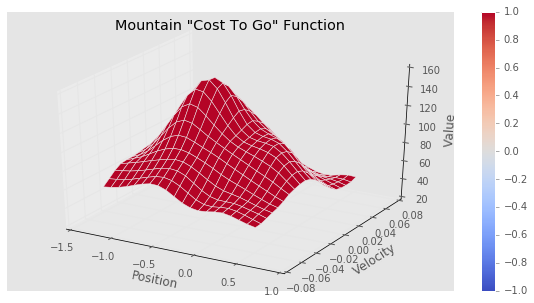

In [296]:
def plot_fa():
    # Plot Q value funciton
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=20)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=20)

    def get_action_value(observation):
        observation_f = featurize_state(observation)
        # X_featurized = create_model_input(np.array(observation), env.action_space.n)
        # X_featurized = featurizer.transform(X_featurized) 
        # print(X_featurized)
        q_values = q_values = np.array([m.predict([observation_f])[0] for m in models])
        return -np.max(q_values)

    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(lambda _: get_action_value(_), 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Position')
        ax.set_ylabel('Velocity')
        ax.set_zlabel('Value')
        ax.set_title(title)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z, "Mountain \"Cost To Go\" Function")

plot_fa()

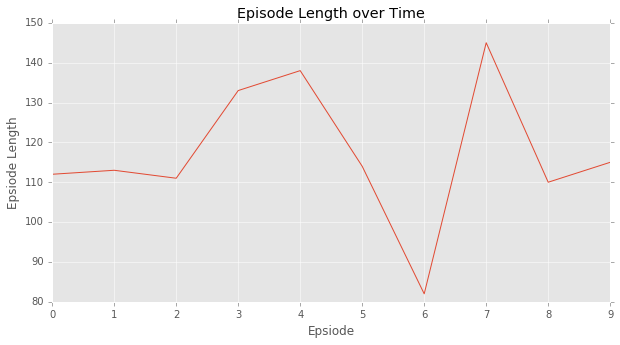

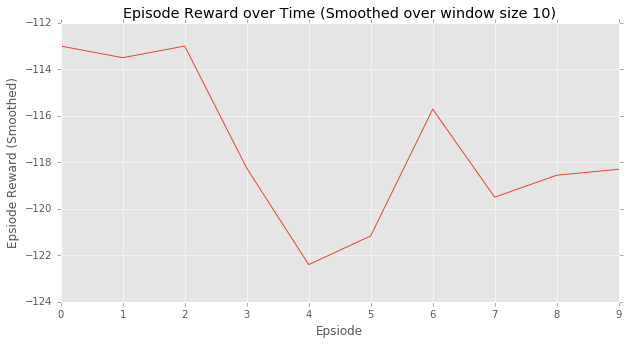

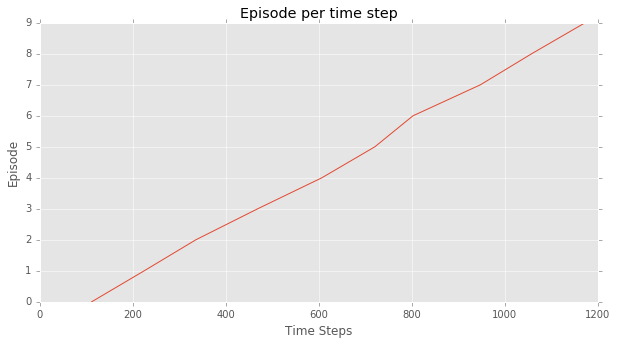

In [294]:
# env.render(close=True)
plotting.plot_episode_stats(stats)

In [295]:
np.mean(stats.episode_rewards)

-118.3